# Курсовой проект

### Задача

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

#### Наименование файлов с данными

course_project_train.csv - обучающий датасет
course_project_test.csv - тестовый датасет

#### Целевая переменная

Credit Default - факт невыполнения кредитных обязательств

#### Метрика качества

F1-score (sklearn.metrics.f1_score)

#### Требования к решению

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

### Обзор данных

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### Подключение библиотек и скриптов

In [1]:
import pandas as pd
import numpy as np
import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter('ignore')

### Пути к директориям и файлам

In [3]:
TRAIN_DATASET_PATH = './course_project_train.csv'
TEST_DATASET_PATH = './course_project_test.csv'

In [4]:
train = pd.read_csv(TRAIN_DATASET_PATH)
test = pd.read_csv(TEST_DATASET_PATH)

## 1. Посмотрим данные 
#### train

In [5]:
train.shape

(7500, 17)

In [6]:
print(train.info(memory_usage='deep'))
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


####  test

In [7]:
test.shape

(2500, 16)

In [8]:
print(test.info(memory_usage='deep'))
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [9]:
#добавим id
#train['id'] = np.arange(0, train.shape[0])

### Приведение типов

In [10]:
for colname in['Number of Open Accounts', 'Number of Credit Problems']:
    train[colname] = train[colname].astype(int)

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   int32  
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   int32  
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [12]:
for colname in['Number of Open Accounts', 'Number of Credit Problems']:
    test[colname] = test[colname].astype(int)

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   int32  
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   int32  
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

### Обзор данных

**Обзор целевой переменной**

In [14]:
train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [15]:
train['Credit Default'].value_counts()[0] / train['Credit Default'].value_counts()[1]

2.549455750118315

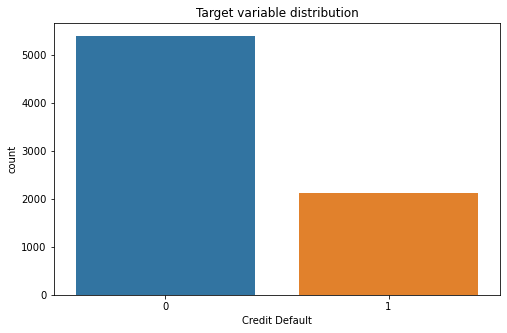

In [16]:
plt.figure(figsize=(8, 5))

sns.countplot(x = 'Credit Default', data = train)

plt.title('Target variable distribution')
plt.show()

**Корреляция с базовыми признаками**

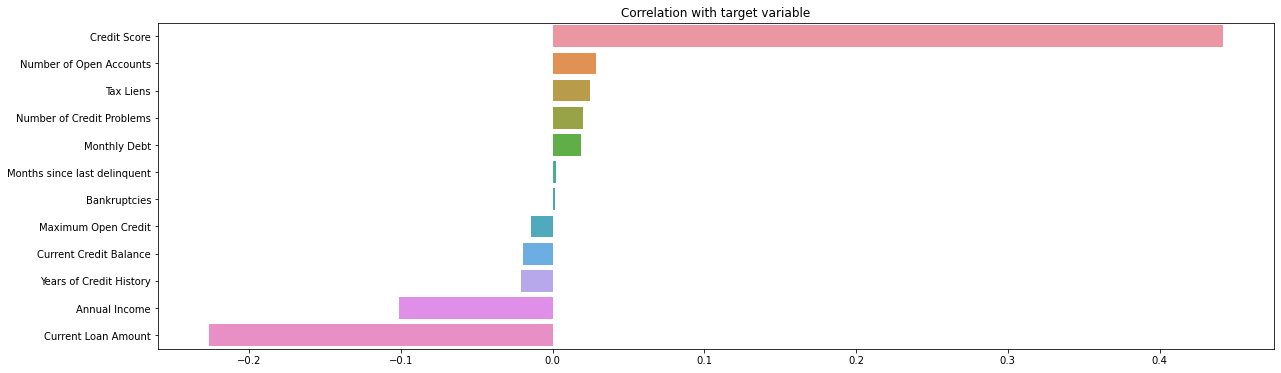

In [17]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = train.columns.drop(TARGET_NAME).tolist()


corr_with_target = train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(20, 6))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()


**Обзор количественных признаков**

In [18]:
train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [19]:
test.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


**Обзор номинативных признаков**

In [20]:
for cat_colname in train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

In [21]:
for cat_colname in test.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(test[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    1225
Rent             1020
Own Home          248
Have Mortgage       7
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    810
3 years      228
2 years      212
< 1 year     207
5 years      169
1 year       153
4 years      152
7 years      140
6 years      137
8 years      107
9 years       99
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
educational expenses       3
vacation                   3
wedding                    2
moving               

**Обработка пропусков**

In [22]:
# Подсчитаем пропуски
(len(train) - train.count()).sort_values(ascending = False)

Months since last delinquent    4081
Annual Income                   1557
Credit Score                    1557
Years in current job             371
Bankruptcies                      14
Maximum Open Credit                0
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Credit Default                     0
Number of Credit Problems          0
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Home Ownership                     0
dtype: int64

Рассмотрим эти пропуски подробнее. При этом количество пропусков в кредитном рейтинге и годовых доходах совпадают.

***Bankruptcies***

Заменим на медианные значения

In [23]:
train["Bankruptcies"].fillna(train["Bankruptcies"].median(),inplace=True)

In [24]:
test["Bankruptcies"].fillna(test["Bankruptcies"].median(),inplace=True)

***Months since last delinquent***

In [25]:
train['Months since last delinquent'].isna().sum()

4081

Больше 50%. Рассмотрим признак в разрезе целевой переменной

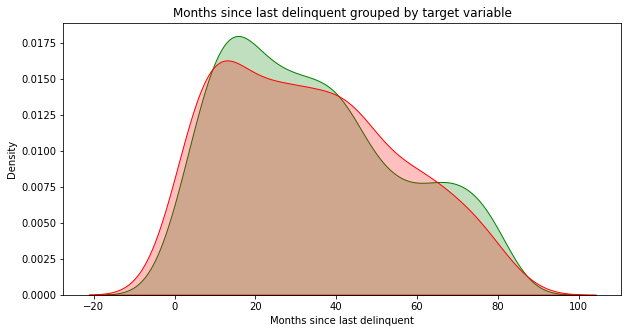

In [26]:
# посмотрим в разрезе целевой переменной
msld_with_target_s = train[['Months since last delinquent', TARGET_NAME]].sample(2000)
msld_s = msld_with_target_s['Months since last delinquent']
msld_target_0 = msld_s[msld_with_target_s[TARGET_NAME] == 0]
msld_target_1 = msld_s[msld_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(msld_target_0, shade=True, label='No default', color='g')
sns.kdeplot(msld_target_1, shade=True, label='Default', color='r')

plt.xlabel('Months since last delinquent')
plt.title('Months since last delinquent grouped by target variable')
plt.show()

In [27]:
import scipy
scipy.stats.shapiro(msld_s)

ShapiroResult(statistic=nan, pvalue=1.0)

In [28]:
scipy.stats.mannwhitneyu(msld_target_0, msld_target_1)

MannwhitneyuResult(statistic=296124.5, pvalue=7.056283023777083e-21)

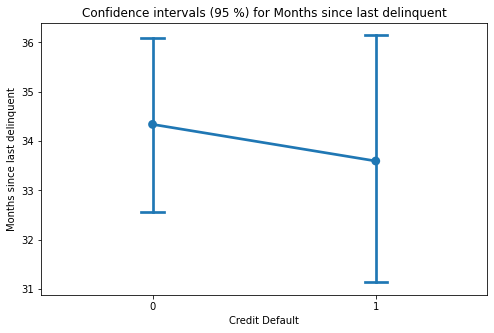

In [29]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Months since last delinquent', data=msld_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Months since last delinquent')
plt.show()

После проверки по всем признакам, становится понятным, что этот признак может быть полезен для определения значения целевой переменной.

Проверим с каким признаком коррелирует для понимания на какое значение будкм заменять.

In [30]:
train.corr()['Months since last delinquent'].sort_values(ascending=False)

Months since last delinquent    1.000000
Bankruptcies                    0.163237
Number of Credit Problems       0.139905
Tax Liens                       0.052446
Credit Default                  0.002598
Current Loan Amount             0.000459
Maximum Open Credit            -0.003849
Credit Score                   -0.004395
Years of Credit History        -0.015375
Current Credit Balance         -0.027198
Number of Open Accounts        -0.032740
Monthly Debt                   -0.057702
Annual Income                  -0.101787
Name: Months since last delinquent, dtype: float64

Ярко выраженной зависимости нет, поэтому заменю на медиану

In [31]:
train["Months since last delinquent"].fillna(train["Months since last delinquent"].median(),inplace=True)

In [32]:
test["Months since last delinquent"].fillna(test["Months since last delinquent"].median(),inplace=True)

***Annual Income***

In [33]:
def get_histplot(x, df=train, hue=TARGET_NAME, xlabel='', ylabel = '\nCount', bins=30):
    ax = sns.histplot(x=x,hue=hue,data=df,bins=bins)
    ax.set_title(f"{x} by {TARGET_NAME}")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel);

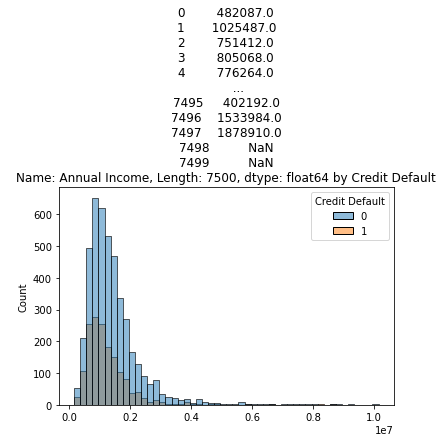

In [34]:
get_histplot(train['Annual Income'],bins=50)

посмотрим признак в разрезе целевой переменной

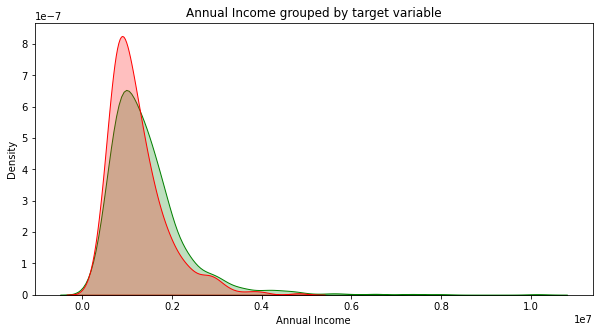

In [35]:
annual_with_target_s = train[['Annual Income', TARGET_NAME]].sample(2000)
annual_s = annual_with_target_s['Annual Income']
annual_target_0 = annual_s[annual_with_target_s[TARGET_NAME] == 0]
annual_target_1 = annual_s[annual_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(annual_target_0, shade=True, label='No default', color='g')
sns.kdeplot(annual_target_1, shade=True, label='Default', color='r')

plt.xlabel('Annual Income')
plt.title('Annual Income grouped by target variable')
plt.show()

In [36]:
scipy.stats.shapiro(annual_s)

ShapiroResult(statistic=nan, pvalue=1.0)

In [37]:
scipy.stats.mannwhitneyu(annual_target_0, annual_target_1)

MannwhitneyuResult(statistic=390617.0, pvalue=0.2403360674842674)

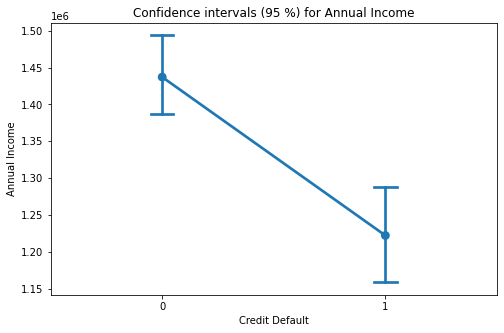

In [38]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Annual Income', data=annual_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Annual Income')
plt.show()

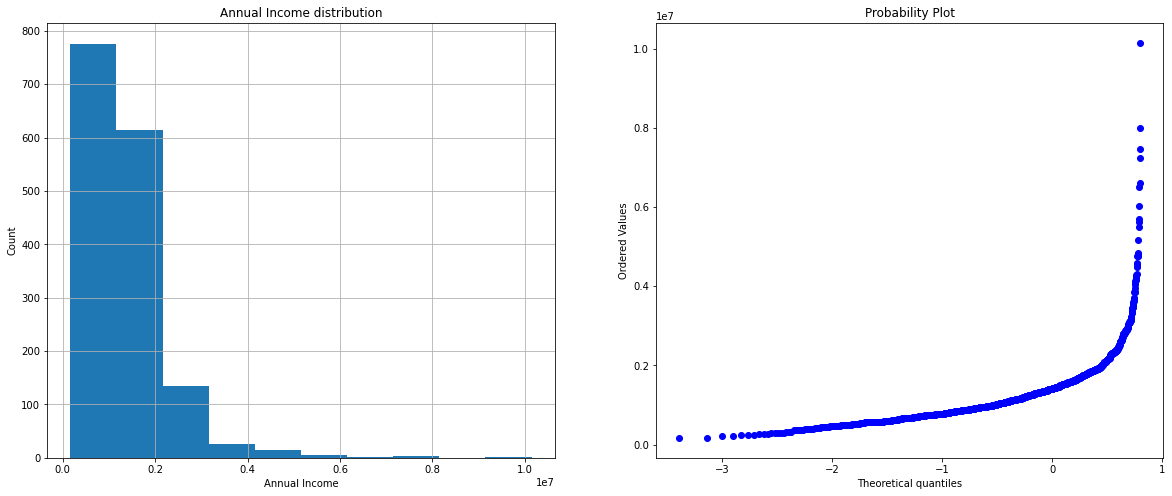

In [39]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Annual Income')
ax1.set_ylabel('Count')
ax1.set_title('Annual Income distribution')
annual_s.hist()

plt.subplot(122)
probplot(annual_s, dist='norm', plot=plt)

plt.show()

очевидно, что "нормальности" нет. Заменим пропуски на медианы

In [40]:
train["Annual Income"].fillna(train["Annual Income"].median(),inplace=True)

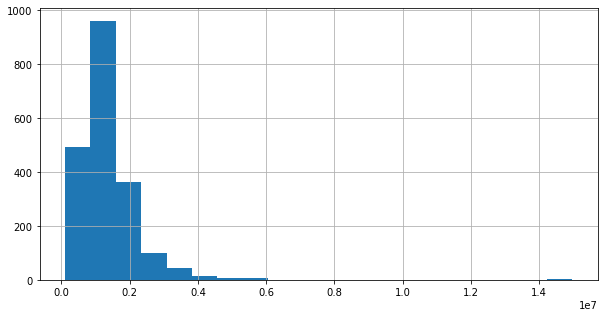

In [41]:
test['Annual Income'].hist(bins=20, figsize=(10, 5))
plt.show()

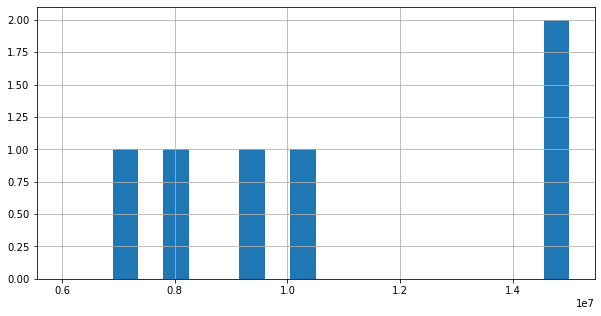

In [42]:
test['Annual Income'].hist(bins=20, range = (6000000, 15000000), figsize=(10, 5))
plt.show()

In [43]:
# очевиден выброс, заменяю сразу
test.loc[test['Annual Income'] > 1.4*10**7, 'Annual Income'] = test['Annual Income'].median()

In [44]:
test[test['Annual Income'] > 1.4*10**7].head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score


In [45]:
test["Annual Income"].fillna(test["Annual Income"].median(),inplace=True)

***Credit Score***

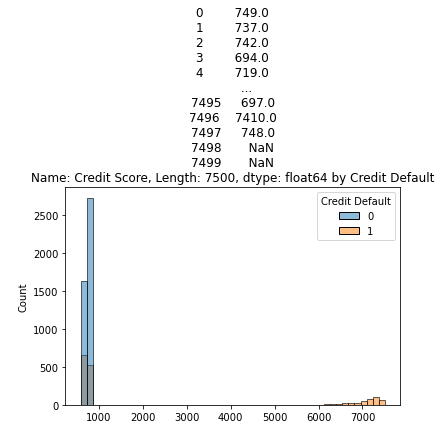

In [46]:
get_histplot(train['Credit Score'],bins=50)

In [47]:
print(train[train['Credit Score'] > 1000].shape[0])
train[train['Credit Score'] > 1000].head()

400


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
69,Home Mortgage,1408527.0,2 years,0.0,12,17.5,700062.0,0,21.0,0.0,other,Long Term,525998.0,174135.0,9320.0,6470.0,1
87,Home Mortgage,1533566.0,7 years,0.0,11,14.8,715462.0,0,19.0,0.0,debt consolidation,Short Term,210826.0,285475.0,18147.0,7440.0,1
94,Rent,1049294.0,3 years,0.0,5,6.1,249810.0,0,32.0,0.0,business loan,Short Term,337502.0,119529.0,15215.0,7010.0,1
96,Rent,757568.0,5 years,0.0,13,11.4,383548.0,0,32.0,0.0,debt consolidation,Short Term,210518.0,276583.0,11553.0,7320.0,1
116,Home Mortgage,1039984.0,NaN,0.0,10,23.8,147950.0,0,63.0,0.0,debt consolidation,Short Term,224246.0,95456.0,13780.0,7390.0,1


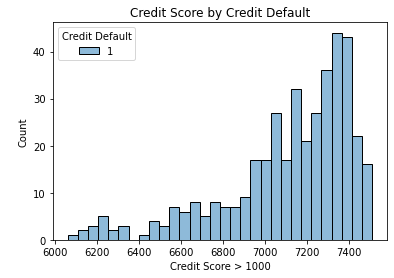

In [48]:
get_histplot(df=train[train['Credit Score'] > 1000],x='Credit Score',xlabel='Credit Score > 1000')

В показателях больше 1000 содержится только один признак (credit_default=1). Разделю на 10.

In [49]:
train.loc[train["Credit Score"] > 1000, 'Credit Score'] = train["Credit Score"] / 10

In [50]:
print(test[test['Credit Score'] > 1000].shape[0])
test[test['Credit Score'] > 1000].head()

160


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
2,Home Mortgage,1152540.0,3 years,0.0,10,13.7,204600.0,0,30.0,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
12,Home Mortgage,1054614.0,2 years,0.0,11,14.0,306328.0,0,69.0,0.0,debt consolidation,Short Term,155408.0,202388.0,14940.0,7030.0
41,Home Mortgage,1735498.0,1 year,0.0,10,13.2,1584506.0,0,30.0,0.0,debt consolidation,Short Term,777172.0,758119.0,30371.0,7320.0
54,Home Mortgage,1602403.0,9 years,0.0,13,18.9,690514.0,0,47.0,0.0,home improvements,Long Term,695266.0,365560.0,16959.0,6340.0
58,Home Mortgage,1238895.0,6 years,0.0,22,17.5,939378.0,0,30.0,0.0,debt consolidation,Short Term,393866.0,499757.0,26017.0,7140.0


In [51]:
test.loc[test["Credit Score"] > 1000, 'Credit Score'] = test["Credit Score"] / 10

Заменим пропущенные значения поля Credit Score

Пыталась заменить "сложно", но жутко увеличилось время обработки + результаты при оценки базовых моделей получалисьбольно "хороши"

In [52]:
#null_credit_score = train[train['Credit Score'].isnull()].index
#not_null_credit_score = train[train['Credit Score'].notnull()].index

In [53]:
#y_train_credit = train.loc[not_null_credit_score, :]
#y_train_credit = y_train_credit['Credit Score']
#X_train_credit = train.loc[not_null_credit_score, :]
#X_train_credit = X_train_credit.drop('Credit Score', axis=1)
#X_train_credit = X_train_credit[['Bankruptcies', 'Number of Credit Problems', 'Maximum Open Credit', 'Years of Credit History', 'Number of Open Accounts']]

In [54]:
#X_test_credit = train.loc[null_credit_score, :]
#X_test_credit = X_test_credit.drop('Credit Score', axis=1)
#X_test_credit = X_test_credit[['Bankruptcies', 'Number of Credit Problems', 'Maximum Open Credit', 'Years of Credit History', 'Number of Open Accounts']]

In [55]:
#from sklearn.model_selection import train_test_split, GridSearchCV
#from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
#parameters = {'n_estimators': [150, 200, 250],
#              'max_features': np.arange(3, 6),
#              'max_depth': np.arange(7, 10)}

#clf_credit = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
#                   param_grid=parameters,
#                   scoring='r2',
#                   cv=4)

In [56]:
#clf_credit.fit(X_train_credit, y_train_credit)

In [57]:
#clf_credit.best_params_

In [58]:
#clf_credit = RandomForestRegressor(max_depth=7, max_features=3, n_estimators=250)
#clf_credit.fit(X_train_credit, y_train_credit)

In [59]:
#y_test_credit = clf_credit.predict(X_test_credit)
#y_test_credit

In [60]:
#train.loc[null_credit_score, 'Credit Score'] = y_test_credit

In [61]:
#null_credit_score = test[test['Credit Score'].isnull()].index
#not_null_credit_score = test[test['Credit Score'].notnull()].index

In [62]:
#y_train_credit = test.loc[not_null_credit_score, :]
#y_train_credit = y_train_credit['Credit Score']
#X_train_credit = test.loc[not_null_credit_score, :]
#X_train_credit = X_train_credit.drop('Credit Score', axis=1)
#X_train_credit = X_train_credit[['Bankruptcies', 'Number of Credit Problems', 'Maximum Open Credit', 'Years of Credit History', 'Number of Open Accounts']]

In [63]:
#y_train_credit = test.loc[not_null_credit_score, :]
#y_train_credit = y_train_credit['Credit Score']
#X_train_credit = test.loc[not_null_credit_score, :]
#X_train_credit = X_train_credit.drop('Credit Score', axis=1)
#X_train_credit = X_train_credit[['Bankruptcies', 'Number of Credit Problems', 'Maximum Open Credit', 'Years of Credit History', 'Number of Open Accounts']]

In [64]:
#X_test_credit = test.loc[null_credit_score, :]
#X_test_credit = X_test_credit.drop('Credit Score', axis=1)
#X_test_credit = X_test_credit[['Bankruptcies', 'Number of Credit Problems', 'Maximum Open Credit', 'Years of Credit History', 'Number of Open Accounts']]

In [65]:
#from sklearn.model_selection import train_test_split, GridSearchCV
#from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
#parameters = {'n_estimators': [150, 200, 250],
#              'max_features': np.arange(3, 6),
#              'max_depth': np.arange(7, 10)}

#clf_credit = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
#                   param_grid=parameters,
 #                  scoring='r2',
#                   cv=4)

In [66]:
#clf_credit.fit(X_train_credit, y_train_credit)

In [67]:
#clf_credit.best_params_

In [68]:
#clf_credit = RandomForestRegressor(max_depth=7, max_features=3, n_estimators=250)
#clf_credit.fit(X_train_credit, y_train_credit)

In [69]:
#y_test_credit = clf_credit.predict(X_test_credit)
#y_test_credit

In [70]:
#test.loc[null_credit_score, 'Credit Score'] = y_test_credit

Заменю пропуски медианой

In [71]:
train.loc[train['Credit Score'].isna(), 'Credit Score'] = train['Credit Score'].median()

In [72]:
test.loc[test['Credit Score'].isna(), 'Credit Score'] = test['Credit Score'].median()

***Years in current job***

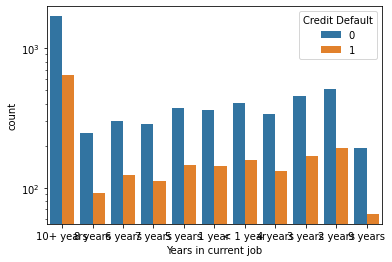

In [73]:
sns.countplot(train['Years in current job'], hue=train['Credit Default'], log=True);

In [74]:
train['Years in current job'].value_counts(normalize=True)

10+ years    0.327115
2 years      0.098892
3 years      0.086969
< 1 year     0.078973
5 years      0.072380
1 year       0.070697
4 years      0.065788
6 years      0.059756
7 years      0.055548
8 years      0.047552
9 years      0.036330
Name: Years in current job, dtype: float64

In [75]:
train.groupby(['Years in current job'])['Credit Default'].mean()

Years in current job
1 year       0.281746
10+ years    0.276158
2 years      0.273759
3 years      0.274194
4 years      0.279318
5 years      0.281008
6 years      0.291080
7 years      0.280303
8 years      0.271386
9 years      0.250965
< 1 year     0.282416
Name: Credit Default, dtype: float64

Заменю пропуски на моду

In [76]:
train['Years in current job'] = train['Years in current job'].replace({'2 years': 2, '3 years': 3, '< 1 year': 0,
                                                                            '5 years': 5, '1 year': 1, '4 years': 4,
                                                                            '6 years': 6, '7 years': 7, '8 years': 8,
                                                                            '9 years': 9, '10+ years': 10})
test['Years in current job'] = test['Years in current job'].replace({'2 years': 2, '3 years': 3, '< 1 year': 0,
                                                                            '5 years': 5, '1 year': 1, '4 years': 4,
                                                                            '6 years': 6, '7 years': 7, '8 years': 8,
                                                                            '9 years': 9, '10+ years': 10})

In [77]:
train['Years in current job'].mode()[0]

10.0

In [78]:
train['Years in current job'].fillna(train['Years in current job'].mode()[0], inplace=True)

In [79]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   float64
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   int32  
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   int32  
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [80]:
test['Years in current job'].mode()[0]

10.0

In [81]:
test['Years in current job'].fillna(test['Years in current job'].mode()[0], inplace=True)

In [82]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 2500 non-null   float64
 2   Years in current job          2500 non-null   float64
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   int32  
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   int32  
 8   Months since last delinquent  2500 non-null   float64
 9   Bankruptcies                  2500 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

**Обзор остальных признаков и обработка выбросов**

***Home Ownership***

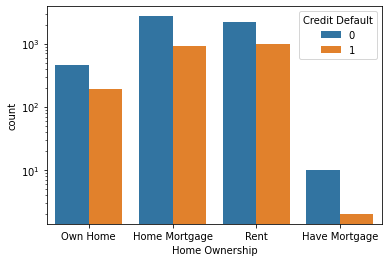

In [83]:
sns.countplot(train['Home Ownership'], hue=train['Credit Default'], log=True);

In [84]:
train['Home Ownership'].value_counts(normalize=True)

Home Mortgage    0.484933
Rent             0.427200
Own Home         0.086267
Have Mortgage    0.001600
Name: Home Ownership, dtype: float64

In [85]:
train.groupby(['Home Ownership'])['Credit Default'].mean()

Home Ownership
Have Mortgage    0.166667
Home Mortgage    0.251856
Own Home         0.296754
Rent             0.313046
Name: Credit Default, dtype: float64

Для переменной Home Ownership доля целевого признака во всех категориях примерно одинакова. Заменю на одну

In [86]:
train['Home Ownership'] = train['Home Ownership'].replace({'Home Mortgage': 1, 'Own Home': 1, 
                                                                     'Have Mortgage': 1, 'Rent': 0})
test['Home Ownership'] = test['Home Ownership'].replace({'Home Mortgage': 1, 'Own Home': 1, 
                                                                     'Have Mortgage': 1, 'Rent': 0})

***Tax Liens***

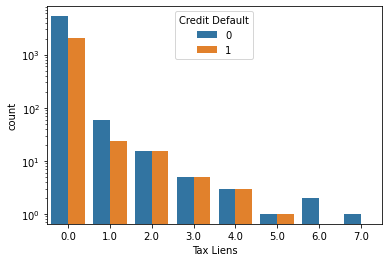

In [87]:
sns.countplot(train['Tax Liens'], hue=train['Credit Default'], log=True);

In [88]:
train['Tax Liens'].value_counts(normalize=True)

0.0    0.982133
1.0    0.011067
2.0    0.004000
3.0    0.001333
4.0    0.000800
5.0    0.000267
6.0    0.000267
7.0    0.000133
Name: Tax Liens, dtype: float64

In [89]:
train.groupby(['Tax Liens'])['Credit Default'].mean()

Tax Liens
0.0    0.280342
1.0    0.289157
2.0    0.500000
3.0    0.500000
4.0    0.500000
5.0    0.500000
6.0    0.000000
7.0    0.000000
Name: Credit Default, dtype: float64

***Number of Open Accounts***

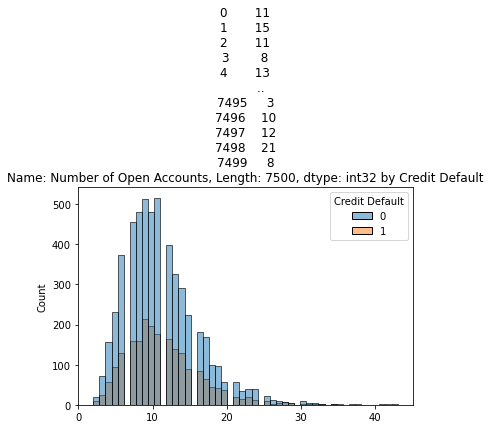

In [90]:
get_histplot(train['Number of Open Accounts'],bins=50)

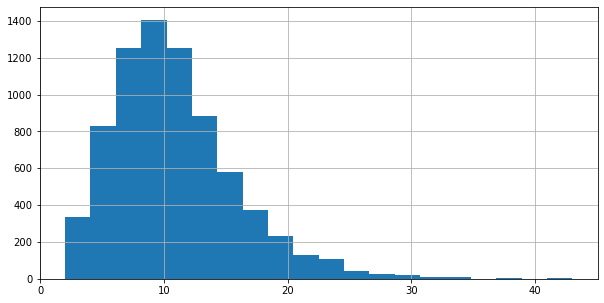

In [91]:
train['Number of Open Accounts'].hist(bins=20, figsize=(10, 5))
plt.show()

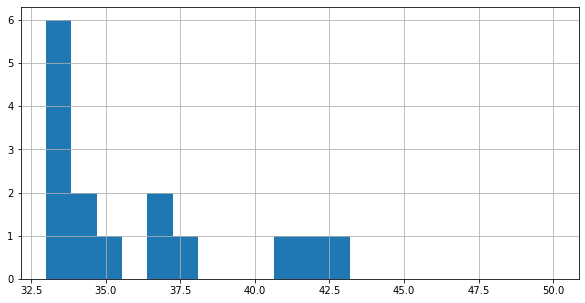

In [92]:
train['Number of Open Accounts'].hist(bins=20, range = (33, 50), figsize=(10, 5))
plt.show()

заменю выброс

In [93]:
train.loc[train['Number of Open Accounts'] > 40, 'Number of Open Accounts'] = train['Number of Open Accounts'].median()

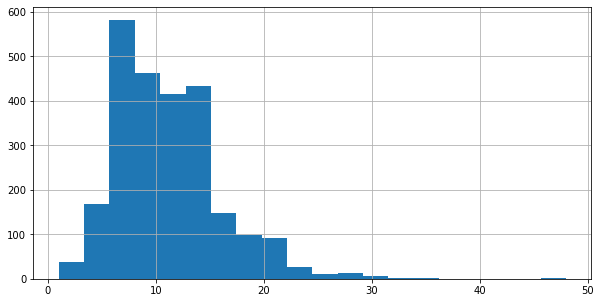

In [94]:
test['Number of Open Accounts'].hist(bins=20, figsize=(10, 5))
plt.show()

In [95]:
test.loc[test['Number of Open Accounts'] > 40, 'Number of Open Accounts'] = test['Number of Open Accounts'].median()

***Years of Credit History***

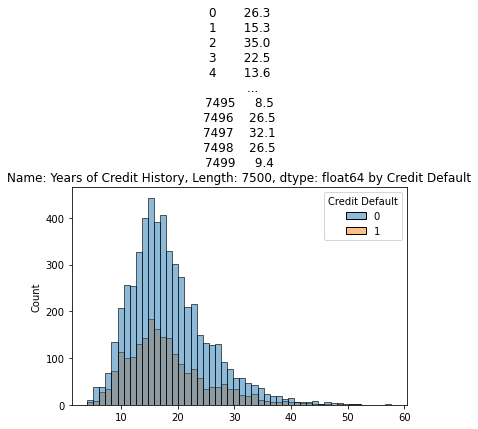

In [96]:
get_histplot(train['Years of Credit History'],bins=50)

посмотрим признак в разрезе целевой переменной

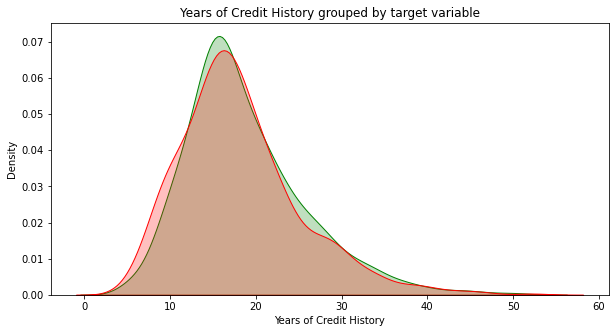

In [97]:
ych_with_target_s = train[['Years of Credit History', TARGET_NAME]].sample(2000)
ych_s = ych_with_target_s['Years of Credit History']
ych_target_0 = ych_s[ych_with_target_s[TARGET_NAME] == 0]
ych_target_1 = ych_s[ych_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(ych_target_0, shade=True, label='No default', color='g')
sns.kdeplot(ych_target_1, shade=True, label='Default', color='r')

plt.xlabel('Years of Credit History')
plt.title('Years of Credit History grouped by target variable')
plt.show()

**Наблюдение**

Похоже что две группы, полученные в результате разбиения признака "Years of Credit History" по целевой переменной, имеют одинаковые распределения, что может помочь при построение модели, т.к. это будет означать, что между признаком "Years of Credit History" и целевой переменной, возможно, существует некоторая функциональная зависимость.

**Гипотеза** 
* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Критерий: критерий Стьюдента (t-тест) и его аналоги
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

Что бы проверить данную гипотезу сравним две выборки из рассматриваемых групп на предмет равенства средних значений.
Если вероятность того, что мат. ожидания в исходных группах равны, при данных выборках, будет менее 5%, то можно будет говорить о том, что скорее всего выборки имеют различные распределения.

In [98]:
scipy.stats.shapiro(ych_s)

ShapiroResult(statistic=0.9414576888084412, pvalue=1.995268044617043e-27)

По полученному значению p-value, которое сильно меньше 0.05, можем заключить, что гипотеза о "нормальности" отвергается.

Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график

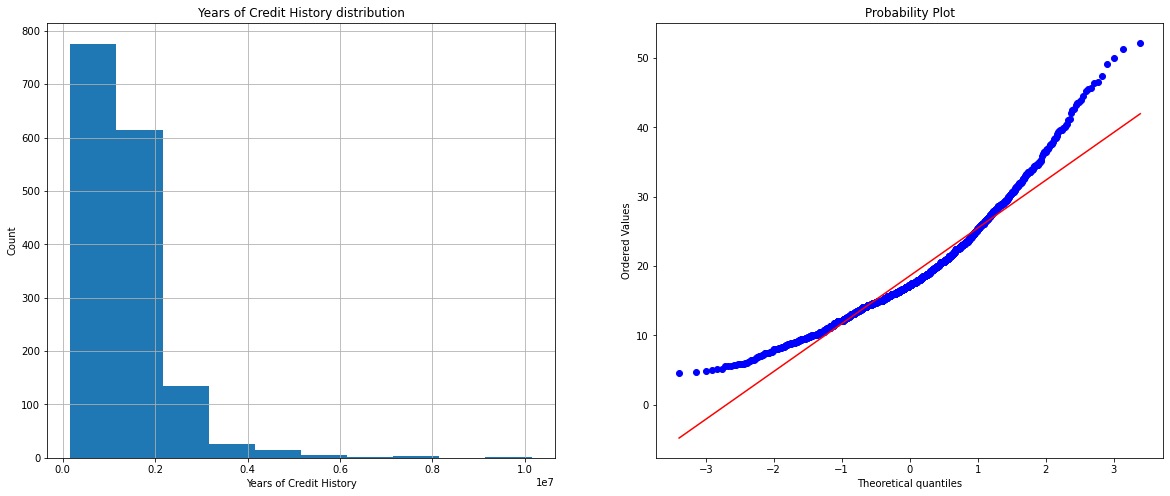

In [99]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Years of Credit History')
ax1.set_ylabel('Count')
ax1.set_title('Years of Credit History distribution')
annual_s.hist()

plt.subplot(122)
probplot(ych_s, dist='norm', plot=plt)

plt.show()

Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни

In [100]:
scipy.stats.mannwhitneyu(ych_target_0, ych_target_1)

MannwhitneyuResult(statistic=392267.5, pvalue=0.030427323821791114)

построим доверительные интервалы

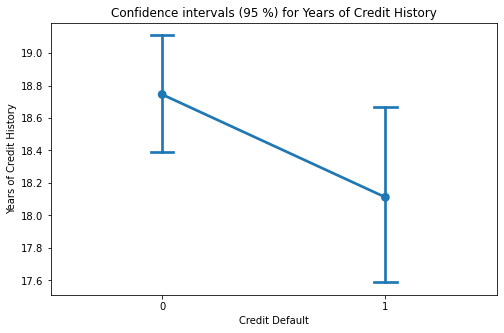

In [101]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Years of Credit History', data=ych_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Years of Credit History')
plt.show()

Очевидно, что группы доверительные интервалы не пересекаются.

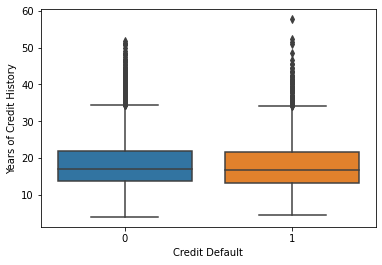

In [102]:
sns.boxplot(x=train['Credit Default'], y=(train['Years of Credit History']));

In [103]:
print(train[train['Years of Credit History'] > 55].shape[0])
train[train['Years of Credit History'] > 55].head()

1


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
476,1,1076768.0,10.0,0.0,14,57.7,432124.0,0,24.0,0.0,debt consolidation,Long Term,558360.0,186219.0,13818.0,667.0,1


In [104]:
train.loc[train['Years of Credit History'] > 55, 'Years of Credit History'] = train['Years of Credit History'].median()

In [105]:
test[test['Years of Credit History'] > 55].head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score


***Maximum Open Credit***

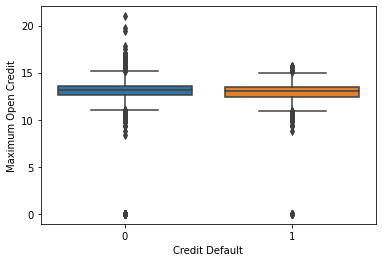

In [106]:
sns.boxplot(x=train['Credit Default'], y=np.log1p(train['Maximum Open Credit']));

In [107]:
print(train[np.log1p(train['Maximum Open Credit']) > 20].shape[0])
train[np.log1p(train['Maximum Open Credit']) > 20]

1


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
617,1,1168386.0,3.0,0.0,13,27.5,1.304726e+09,0,32.0,0.0,debt consolidation,Short Term,529892.0,1126814.0,5492.0,729.0,0


In [108]:
print(train[np.log1p(train['Maximum Open Credit']) == 0].shape[0])
train[np.log1p(train['Maximum Open Credit']) == 0].head()

65


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
8,1,1168386.0,5.0,0.0,17,15.7,0.0,1,32.0,1.0,home improvements,Short Term,129734.0,19.0,17.0,729.0,0
91,0,601369.0,10.0,0.0,6,16.9,0.0,0,14.0,0.0,debt consolidation,Short Term,165924.0,0.0,9021.0,738.0,0
196,0,815157.0,7.0,0.0,3,8.8,0.0,0,32.0,0.0,small business,Short Term,218042.0,0.0,5855.0,738.0,0
294,1,2033931.0,7.0,0.0,6,21.1,0.0,0,32.0,0.0,home improvements,Short Term,108042.0,0.0,30340.0,742.0,0
309,0,1245792.0,3.0,0.0,5,22.4,0.0,0,58.0,0.0,major purchase,Long Term,338096.0,0.0,395.0,659.0,0


заменим на медиану

In [109]:
train.loc[train['Maximum Open Credit'] > 20, 'Maximum Open Credit'] = train['Maximum Open Credit'].median()

In [110]:
print(test[np.log1p(test['Maximum Open Credit']) > 20].shape[0])
test[np.log1p(test['Maximum Open Credit']) > 20]

0


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score


***Number of Credit Problems***

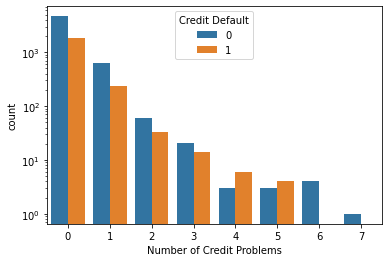

In [111]:
sns.countplot(train['Number of Credit Problems'], hue=train['Credit Default'], log=True);

In [112]:
train['Number of Credit Problems'].value_counts(normalize=True)

0    0.862533
1    0.117600
2    0.012400
3    0.004667
4    0.001200
5    0.000933
6    0.000533
7    0.000133
Name: Number of Credit Problems, dtype: float64

In [113]:
train.groupby(['Number of Credit Problems'])['Credit Default'].mean()

Number of Credit Problems
0    0.280569
1    0.273243
2    0.354839
3    0.400000
4    0.666667
5    0.571429
6    0.000000
7    0.000000
Name: Credit Default, dtype: float64

***Months since last delinquent***

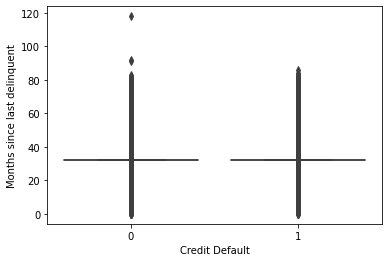

In [114]:
sns.boxplot(x=train['Credit Default'], y=train['Months since last delinquent']);

In [115]:
print(train[train['Months since last delinquent'] > 100].shape[0])
train[train['Months since last delinquent'] > 100].head()

1


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
4191,1,3009201.0,6.0,0.0,10,20.8,478159.0,0,118.0,0.0,debt consolidation,Short Term,449592.0,299877.0,15297.0,738.0,0


In [116]:
train.loc[train['Months since last delinquent'] > 100, 'Months since last delinquent'] = train['Months since last delinquent'].median()

In [117]:
print(test[test['Months since last delinquent'] > 100].shape[0])
test[test['Months since last delinquent'] > 100].head()

0


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score


***Bankruptcies***

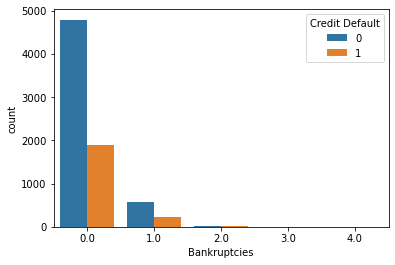

In [118]:
sns.countplot(train['Bankruptcies'].fillna(-1), hue=train['Credit Default']);

In [119]:
train['Bankruptcies'].fillna(-1).value_counts(normalize=True)

0.0    0.889867
1.0    0.104800
2.0    0.004133
3.0    0.000933
4.0    0.000267
Name: Bankruptcies, dtype: float64

In [120]:
train.groupby(train['Bankruptcies'].fillna(-1))['Credit Default'].mean()

Bankruptcies
0.0    0.281990
1.0    0.276081
2.0    0.354839
3.0    0.285714
4.0    0.500000
Name: Credit Default, dtype: float64

***Purpose***

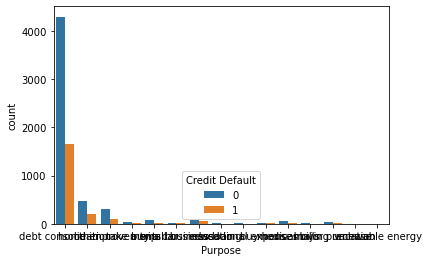

In [121]:
sns.countplot(train['Purpose'], hue=train['Credit Default']);

In [122]:
train['Purpose'].value_counts(normalize=True)

debt consolidation      0.792533
other                   0.088667
home improvements       0.054933
business loan           0.017200
buy a car               0.012800
medical bills           0.009467
major purchase          0.005333
take a trip             0.004933
buy house               0.004533
small business          0.003467
wedding                 0.002000
moving                  0.001467
educational expenses    0.001333
vacation                0.001067
renewable energy        0.000267
Name: Purpose, dtype: float64

In [123]:
train.groupby(['Purpose'])['Credit Default'].mean()

Purpose
business loan           0.426357
buy a car               0.250000
buy house               0.264706
debt consolidation      0.278264
educational expenses    0.100000
home improvements       0.262136
major purchase          0.225000
medical bills           0.309859
moving                  0.181818
other                   0.296241
renewable energy        1.000000
small business          0.538462
take a trip             0.270270
vacation                0.250000
wedding                 0.266667
Name: Credit Default, dtype: float64

Разделю на 2 группы

In [124]:
train['Purpose'] = train['Purpose'].replace({'other': 1, 'home improvements': 1, 
                                                                              'business loan': 1, 'buy a car': 1,
                                                                              'medical bills': 1, 'major purchase': 1,
                                                                              'take a trip': 1, 'buy house': 1,
                                                                              'small business': 1, 'wedding': 1,
                                                                              'moving': 1, 'educational expenses': 1,
                                                                              'vacation': 1, 'renewable energy': 1,
                                                                              'debt consolidation': 0})
test['Purpose'] = test['Purpose'].replace({'other': 1, 'home improvements': 1, 
                                                                              'business loan': 1, 'buy a car': 1,
                                                                              'medical bills': 1, 'major purchase': 1,
                                                                              'take a trip': 1, 'buy house': 1,
                                                                              'small business': 1, 'wedding': 1,
                                                                              'moving': 1, 'educational expenses': 1,
                                                                              'vacation': 1, 'renewable energy': 1,
                                                                              'debt consolidation': 0})

***Term***

In [125]:
train['Term'].value_counts(normalize=True)

Short Term    0.7408
Long Term     0.2592
Name: Term, dtype: float64

In [126]:
train.groupby(['Term'])['Credit Default'].mean()

Term
Long Term     0.419753
Short Term    0.233441
Name: Credit Default, dtype: float64

In [127]:
train.rename(columns={'Term': 'Longterm Credit'}, 
               inplace=True)
test.rename(columns={'Term': 'Longterm Credit'}, 
               inplace=True)

In [128]:
train['Longterm Credit'] = train['Longterm Credit'].replace({'Short Term': 1, 'Long Term': 0})
test['Longterm Credit'] = test['Longterm Credit'].replace({'Short Term': 1, 'Long Term': 0})

***Current Loan Amount***

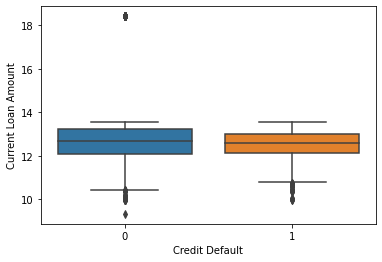

In [129]:
sns.boxplot(x=train['Credit Default'], y=np.log1p(train['Current Loan Amount']));

In [130]:
print(train[np.log1p(train['Current Loan Amount']) > 16].shape[0])
train[np.log1p(train['Current Loan Amount']) > 16].head()

870


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Longterm Credit,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,1,482087.0,10.0,0.0,11,26.3,478159.0,1,32.0,1.0,0,1,99999999.0,47386.0,7914.0,749.0,0
2,1,751412.0,8.0,0.0,11,35.0,478159.0,0,32.0,0.0,0,1,99999999.0,308389.0,13651.0,742.0,0
6,1,1511108.0,10.0,0.0,9,20.3,478159.0,0,73.0,0.0,1,1,99999999.0,51623.0,2317.0,745.0,0
22,0,463790.0,10.0,0.0,6,28.3,478159.0,0,32.0,0.0,0,1,99999999.0,157700.0,5063.0,738.0,0
27,0,1004055.0,8.0,0.0,7,14.5,478159.0,0,32.0,0.0,0,1,99999999.0,195966.0,6041.0,734.0,0


слишком много. оставляю

***Current Credit Balance***

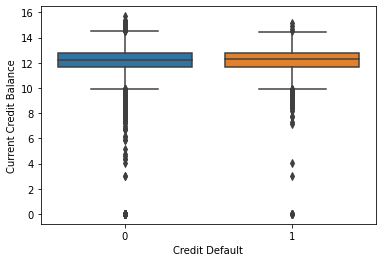

In [131]:
sns.boxplot(x=train['Credit Default'], y=np.log1p(train['Current Credit Balance']));

In [132]:
print(train[np.log1p(train['Current Credit Balance']) == 0].shape[0])
train[np.log1p(train['Current Credit Balance']) == 0].head()

53


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Longterm Credit,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
91,0,601369.0,10.0,0.0,6,16.9,0.0,0,14.0,0.0,0,1,165924.0,0.0,9021.0,738.0,0
196,0,815157.0,7.0,0.0,3,8.8,0.0,0,32.0,0.0,1,1,218042.0,0.0,5855.0,738.0,0
294,1,2033931.0,7.0,0.0,6,21.1,0.0,0,32.0,0.0,1,1,108042.0,0.0,30340.0,742.0,0
309,0,1245792.0,3.0,0.0,5,22.4,0.0,0,58.0,0.0,1,0,338096.0,0.0,395.0,659.0,0
319,1,1168386.0,0.0,0.0,2,10.5,0.0,0,32.0,0.0,1,1,76670.0,0.0,6432.0,729.0,0


***Monthly Debt***

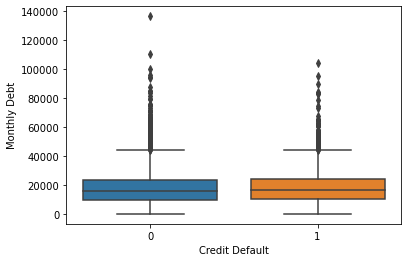

In [133]:
sns.boxplot(x=train['Credit Default'], y=(train['Monthly Debt']));

In [134]:
print(train[train['Monthly Debt'] > 120000].shape[0])
train[train['Monthly Debt'] > 120000].head()

1


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Longterm Credit,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
4745,1,6029954.0,4.0,0.0,30,17.5,478159.0,0,32.0,0.0,0,1,753588.0,4720132.0,136679.0,745.0,0


In [135]:
train.loc[train['Monthly Debt'] > 120000, 'Monthly Debt'] = train['Monthly Debt'].median()

In [136]:
print(test[test['Monthly Debt'] > 120000].shape[0])
test[test['Monthly Debt'] > 120000].head()

0


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Longterm Credit,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score


***Credit Score***

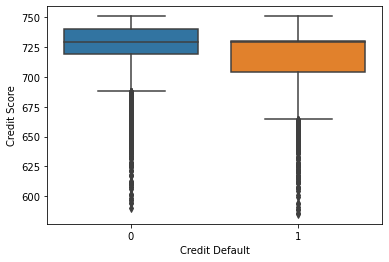

In [137]:
sns.boxplot(x=train['Credit Default'], y=(train['Credit Score']));

In [138]:
train['Home Ownership'] = train['Home Ownership'].astype('str')
train['Years in current job'] = train['Years in current job'].astype('str')
train['Purpose'] = train['Purpose'].astype('str')
train['Longterm Credit'] = train['Longterm Credit'].astype('str')

In [139]:
test['Home Ownership'] = test['Home Ownership'].astype('str')
test['Years in current job'] = test['Years in current job'].astype('str')
test['Purpose'] = test['Purpose'].astype('str')
test['Longterm Credit'] = test['Longterm Credit'].astype('str')

In [140]:
print(train.shape)

(7500, 17)


In [141]:
train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Longterm Credit,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,1,482087.0,10.0,0.0,11,26.3,478159.0,1,32.0,1.0,0,1,99999999.0,47386.0,7914.0,749.0,0
1,1,1025487.0,10.0,0.0,15,15.3,478159.0,0,32.0,0.0,0,0,264968.0,394972.0,18373.0,737.0,1
2,1,751412.0,8.0,0.0,11,35.0,478159.0,0,32.0,0.0,0,1,99999999.0,308389.0,13651.0,742.0,0
3,1,805068.0,6.0,0.0,8,22.5,478159.0,1,32.0,1.0,0,1,121396.0,95855.0,11338.0,694.0,0
4,0,776264.0,8.0,0.0,13,13.6,478159.0,1,32.0,0.0,0,1,125840.0,93309.0,7180.0,719.0,0


In [142]:
print(test.shape)

(2500, 16)


In [143]:
test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Longterm Credit,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,0,1178475.0,4.0,0.0,9,12.5,220968.0,0,70.0,0.0,0,1,162470.0,105906.0,6813.0,727.0
1,0,231838.0,1.0,0.0,6,32.7,55946.0,0,8.0,0.0,1,1,78298.0,46037.0,2318.0,699.0
2,1,1152540.0,3.0,0.0,10,13.7,204600.0,0,30.0,0.0,0,1,200178.0,146490.0,18729.0,726.0
3,1,1220313.0,10.0,0.0,16,17.0,456302.0,0,70.0,0.0,0,1,217382.0,213199.0,27559.0,739.0
4,1,2340952.0,6.0,0.0,11,23.6,1207272.0,0,30.0,0.0,0,0,777634.0,425391.0,42605.0,706.0


**Матрица корреляций**

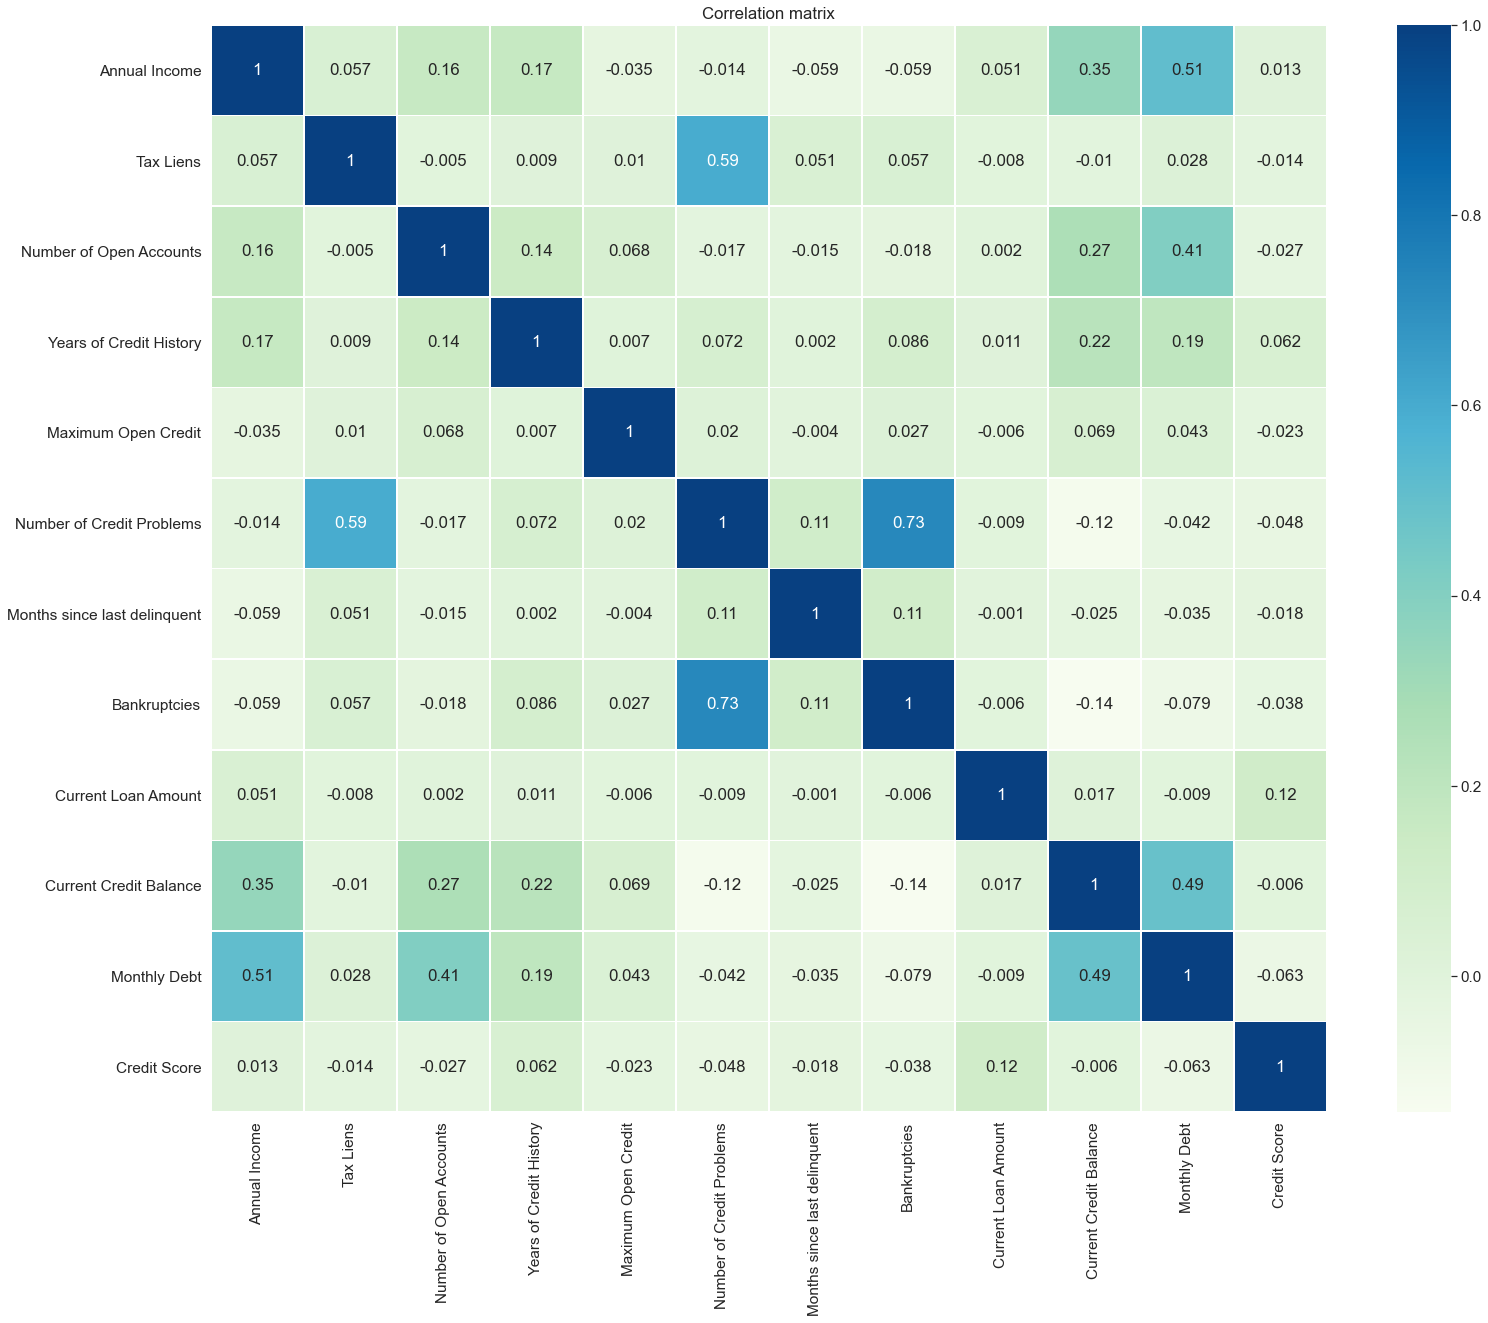

In [144]:
BASE_FEATURE_NAMES = train.columns.drop(TARGET_NAME).tolist()
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(train[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

**Нормализация данных и балансировка целевой переменной**

In [145]:
train.to_csv('train_processed.csv', encoding='utf-8', index=False)
test.to_csv('test_processed.csv', encoding='utf-8', index=False)

In [146]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   int32  
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   int32  
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Longterm Credit               7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [147]:
train.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose',
       'Longterm Credit', 'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt', 'Credit Score', 'Credit Default'],
      dtype='object')

In [148]:
cat_features = [col for col in train.columns if train[col].dtype == 'object']
cat_features

['Home Ownership', 'Years in current job', 'Purpose', 'Longterm Credit']

In [149]:
for colname in cat_features:
    train[colname] = pd.Categorical(train[colname])
    
train[cat_features].dtypes

Home Ownership          category
Years in current job    category
Purpose                 category
Longterm Credit         category
dtype: object

In [150]:
num_features = ['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [151]:
from sklearn.preprocessing import StandardScaler

In [152]:
train_norm = train.copy()

In [153]:
scaler = StandardScaler()

train_norm[num_features] = scaler.fit_transform(train_norm[num_features])

In [155]:
y = train_norm['Credit Default']
X = train_norm.drop(columns=['Credit Default'], axis=1)


In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=21)

**Логистическая регрессия**

In [157]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

In [158]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [159]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.74      0.95      0.83      3771
           1       0.57      0.16      0.26      1479

    accuracy                           0.73      5250
   macro avg       0.66      0.56      0.55      5250
weighted avg       0.69      0.73      0.67      5250

TEST

              precision    recall  f1-score   support

           0       0.74      0.95      0.83      1616
           1       0.56      0.16      0.25       634

    accuracy                           0.73      2250
   macro avg       0.65      0.56      0.54      2250
weighted avg       0.69      0.73      0.67      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1537   79
1                532  102


**k ближайших соседей**

In [160]:
from sklearn.neighbors import KNeighborsClassifier

In [161]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.80      0.92      0.86      3771
           1       0.68      0.40      0.51      1479

    accuracy                           0.78      5250
   macro avg       0.74      0.66      0.68      5250
weighted avg       0.76      0.78      0.76      5250

TEST

              precision    recall  f1-score   support

           0       0.74      0.84      0.79      1616
           1       0.38      0.24      0.30       634

    accuracy                           0.67      2250
   macro avg       0.56      0.54      0.54      2250
weighted avg       0.64      0.67      0.65      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1364  252
1                480  154


**Бустинговые алгоритмы**

*XGBoost*

In [162]:
import xgboost as xgb, lightgbm as lgbm, catboost as catb

In [163]:
for feature in cat_features:
    train[feature] = train[feature].astype('float32')

In [164]:
y = train['Credit Default']
X = train.drop('Credit Default', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=21)

In [165]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

[20:21:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3771
           1       0.99      0.85      0.91      1479

    accuracy                           0.95      5250
   macro avg       0.97      0.92      0.94      5250
weighted avg       0.96      0.95      0.95      5250

TEST

              precision    recall  f1-score   support

           0       0.74      0.86      0.79      1616
           1       0.40      0.24      0.30       634

    accuracy                           0.68      2250
   macro avg       0.57      0.55      0.55      2250
weighted avg       0.64      0.68      0.66      2250

CONFUSION MATRIX

col_0

*LightGBM*

In [166]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.99      0.92      3771
           1       0.97      0.60      0.74      1479

    accuracy                           0.88      5250
   macro avg       0.92      0.80      0.83      5250
weighted avg       0.89      0.88      0.87      5250

TEST

              precision    recall  f1-score   support

           0       0.74      0.90      0.81      1616
           1       0.44      0.21      0.28       634

    accuracy                           0.70      2250
   macro avg       0.59      0.55      0.55      2250
weighted avg       0.66      0.70      0.66      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1448  168
1                503  131


Посмотрим на кривые валидации и обучения.

In [167]:
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve

In [168]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

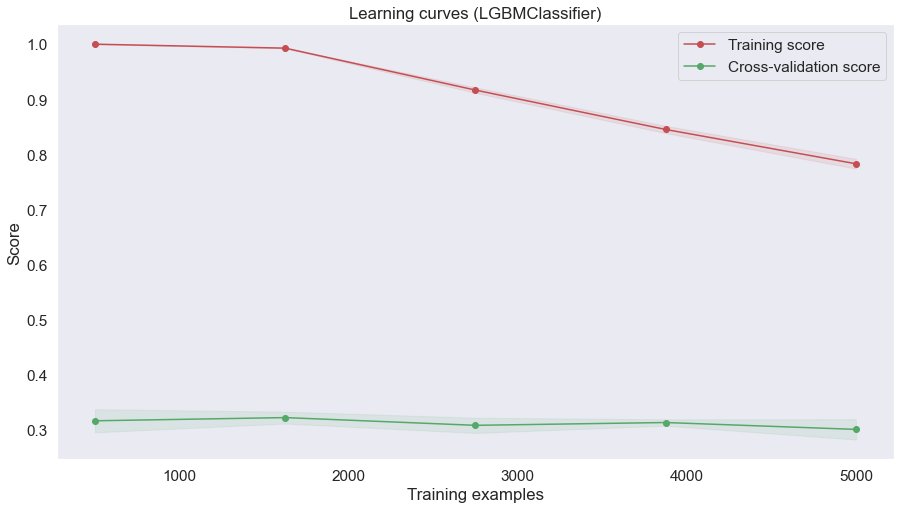

In [169]:
show_learning_curve_plot(model_lgbm, X, y)

Оценим порог вероятности.

In [170]:
y_test_proba = model_lgbm.predict_proba(X_test)[:, 1]

In [171]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

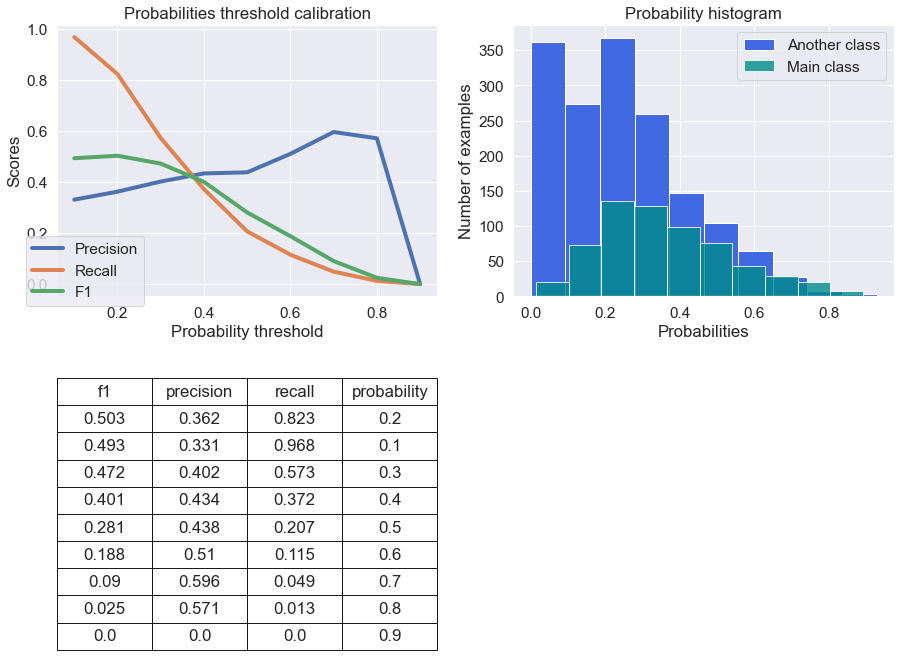

In [172]:
show_proba_calibration_plots(y_test_proba, y_test)

Отберём признаки по feature_importance.

In [173]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

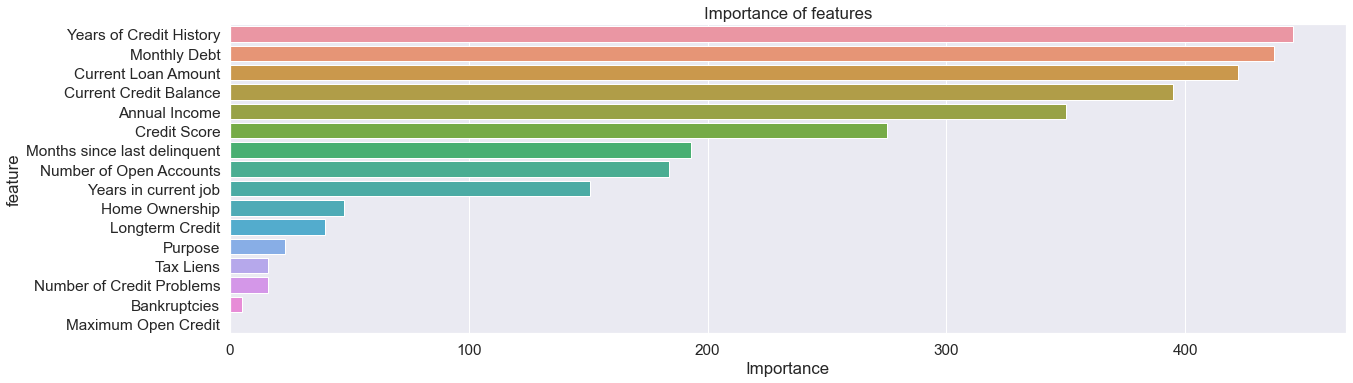

In [174]:
important_features_top = show_feature_importances(X_train.columns, model_lgbm.feature_importances_, get_top=12)

In [175]:
%%time

model_lightgbm = lgbm.LGBMClassifier(random_state=43, 
                                     boosting_type='dart',
                                     metric='logloss',
                                     silent=False, 
                                     scoring='f1',
                                     learning_rate=0.07, 
                                     max_depth=3, 
                                     min_data_in_leaf=15,
                                     num_leaves=5, 
                                     num_iterations=100, 
                                     is_unbalance=True,
                                     data_random_seed=17, 
                                     feature_fraction=0.95)

model_lightgbm.fit(X_train[important_features_top], y_train)

y_train_pred = model_lightgbm.predict(X_train[important_features_top])
y_test_pred = model_lightgbm.predict(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

[LightGBM] [Warning] Unknown parameter: scoring
[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: scoring
[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1479, number of negative: 3771
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1542
[LightGBM] [Info] Number of data points in the train set: 52

**Предсказание на тестовых данных**


Выбираю LGBM

In [176]:
test = pd.read_csv('test_processed.csv', encoding='utf-8')
test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Longterm Credit,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,0,1178475.0,4.0,0.0,9,12.5,220968.0,0,70.0,0.0,0,1,162470.0,105906.0,6813.0,727.0
1,0,231838.0,1.0,0.0,6,32.7,55946.0,0,8.0,0.0,1,1,78298.0,46037.0,2318.0,699.0
2,1,1152540.0,3.0,0.0,10,13.7,204600.0,0,30.0,0.0,0,1,200178.0,146490.0,18729.0,726.0
3,1,1220313.0,10.0,0.0,16,17.0,456302.0,0,70.0,0.0,0,1,217382.0,213199.0,27559.0,739.0
4,1,2340952.0,6.0,0.0,11,23.6,1207272.0,0,30.0,0.0,0,0,777634.0,425391.0,42605.0,706.0


In [178]:
model_lightgbm.fit(train[important_features_top], train['Credit Default'])
y_pred = model_lightgbm.predict(test[important_features_top])
predictions = pd.DataFrame(y_pred, columns=['Credit Default'])

[LightGBM] [Warning] Unknown parameter: scoring
[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: scoring
[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 2113, number of negative: 5387
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1551
[LightGBM] [Info] Number of data points in the train set: 75

In [179]:
predictions.head()

,Credit Default
0,1
1,1
2,0
3,0
4,1


In [180]:
predictions.to_csv('NGladkova_predictions_final.csv', index=True, encoding='utf-8')